# Index

### Table of Contents

Input index here once all sections are finalised!

# Introduction

 * What is the Project
 * Why is it important
 * How will we go about doing it

# Data size and structure

The Data's size and structure 

# Load Dependencies

In [42]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# Data Collection

In [4]:
df_train = pd.read_csv('resources/train.csv')
df_test = pd.read_csv('resources/test.csv')
df_sample_submission = pd.read_csv('resources/sample_submission.csv')
df_movies = pd.read_csv('resources/movies.csv')
df_imdb = pd.read_csv('resources/imdb_data.csv')
df_genome_scores = pd.read_csv('resources/genome_scores.csv')
df_genome_tags = pd.read_csv('resources/genome_tags.csv')
df_tags = pd.read_csv('resources/tags.csv')
df_links = pd.read_csv('resources/links.csv')

In [5]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
df_sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [12]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [13]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


# Data Preprocessing

## Checking for Missing Values

Kaggle tries to provide us with clean data but it's always a good idea to check for ourselves. We check for null and empty values.

In [10]:
df_train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [14]:
i=0
for x in df_train.columns:
    if '' in sorted(df_train[x].unique()):
        i+=1
print('The data contains '+str(i)+' empty values over all columns')

The data contains 0 empty values over all columns


None of our columns contain any null or empty values.

## Checking for Duplicate Values

Checking for duplicate values in the dataset using the .duplicated which returns a boolean Series denoting duplicate rows

In [17]:
# Store dDuplications
val_bool = df_train.duplicated(['userId', 'movieId', 'rating'])

# Show Duplications
print("Number of duplicated values:", sum(val_bool))


Number of duplicated values: 0


## Length of Unique Values

In [32]:
print("Number of unique userID values :",len(df_train['userId'].unique()),
      "\nNumber of unique movieId values :",len(df_train['movieId'].unique()))
#, )

Number of unique userID values : 162541 
Number of unique movieId values : 48213


In [38]:
len(df_movies['movieId'].unique())

62423

## Exploratory Data Anaylsis

Most common Genres

In [10]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


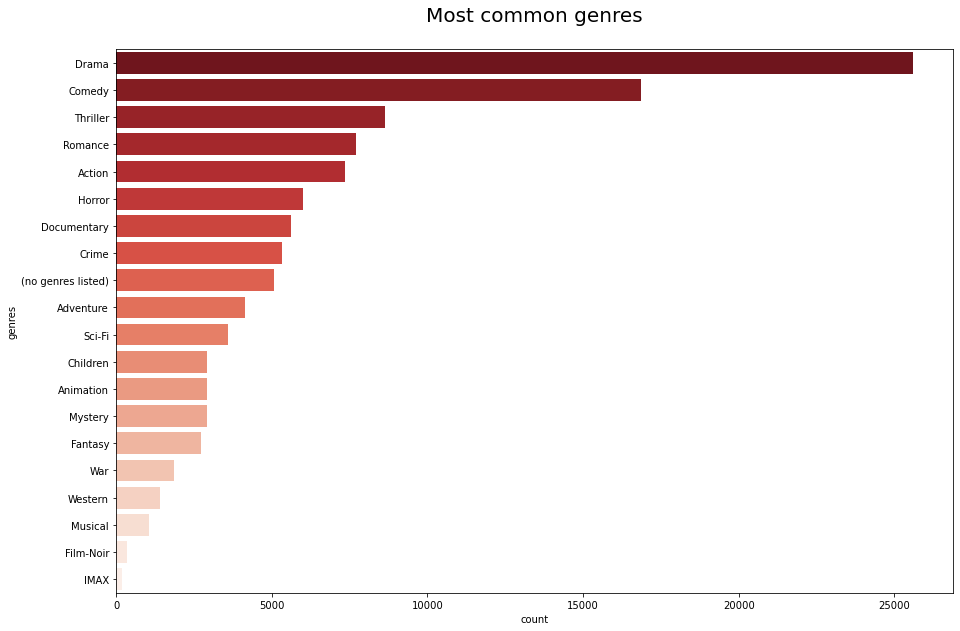

In [11]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

# Model Selection

SVD

In [40]:
# Loading as Surprise dataframe
train_copy = df_train.copy()
reader = Reader()
# Data selected for model training
data = Dataset.load_from_df(train_copy[['userId', 'movieId', 'rating']], reader)

In [43]:
# Data split 99/1
trainset, testset = train_test_split(data, test_size=0.01)

In [44]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


## Training and Fitting the model

In [45]:
svd_model = SVD()

In [46]:
svd_model.fit(trainset)

In [47]:
# Making predictions using the testset
predictions = svd_model.test(testset) 
predictions

test = pd.DataFrame(predictions)

In [48]:
test.head()

,uid,iid,r_ui,est,details
0,11646,5378,4.0,3.922982,{'was_impossible': False}
1,49809,4226,4.0,4.307851,{'was_impossible': False}
2,137544,288,3.0,3.349603,{'was_impossible': False}
3,55263,454,5.0,4.161782,{'was_impossible': False}
4,105575,114180,5.0,3.831887,{'was_impossible': False}


In [51]:
# We are trying to predict ratings for every userId / movieId pair, we implement the below list comprehension to achieve this.
ratings_predictions=[svd_model.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]
ratings_predictions

[Prediction(uid=1, iid=2011, r_ui=None, est=3.2869408969565113, details={'was_impossible': False}),
 Prediction(uid=1, iid=4144, r_ui=None, est=4.354662135006187, details={'was_impossible': False}),
 Prediction(uid=1, iid=5767, r_ui=None, est=3.835789627998257, details={'was_impossible': False}),
 Prediction(uid=1, iid=6711, r_ui=None, est=3.856459992879428, details={'was_impossible': False}),
 Prediction(uid=1, iid=7318, r_ui=None, est=2.759904158841757, details={'was_impossible': False}),
 Prediction(uid=1, iid=8405, r_ui=None, est=3.9399196671623278, details={'was_impossible': False}),
 Prediction(uid=1, iid=8786, r_ui=None, est=4.0084114537923385, details={'was_impossible': False}),
 Prediction(uid=2, iid=150, r_ui=None, est=3.629278521632265, details={'was_impossible': False}),
 Prediction(uid=2, iid=356, r_ui=None, est=3.3621202675696535, details={'was_impossible': False}),
 Prediction(uid=2, iid=497, r_ui=None, est=3.6217975314817843, details={'was_impossible': False}),
 Predict

In [52]:
# Converting our prediction into a Dataframe
df_pred=pd.DataFrame(ratings_predictions)
df_pred

,uid,iid,r_ui,est,details
0,1,2011,None,3.286941,{'was_impossible': False}
1,1,4144,None,4.354662,{'was_impossible': False}
2,1,5767,None,3.835790,{'was_impossible': False}
3,1,6711,None,3.856460,{'was_impossible': False}
4,1,7318,None,2.759904,{'was_impossible': False}
...,...,...,...,...,...
5000014,162541,4079,None,3.427132,{'was_impossible': False}
5000015,162541,4467,None,3.829274,{'was_impossible': False}
5000016,162541,4980,None,2.738565,{'was_impossible': False}
5000017,162541,5689,None,2.870142,{'was_impossible': False}


In [53]:
# Renaming our predictions to original names
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [54]:
df_pred.head()

,userId,movieId,rating
0,1,2011,3.286941
1,1,4144,4.354662
2,1,5767,3.835790
3,1,6711,3.856460
4,1,7318,2.759904


In [56]:
# Need to run this code more than once to improve the outcome
for i in range(2):
    df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [57]:
# View the first five rows of the dataframe
df_pred.head(5)

,userId,movieId,rating,Id
0,1,2011,3.286941,1_2011
1,1,4144,4.354662,1_4144
2,1,5767,3.835790,1_5767
3,1,6711,3.856460,1_6711
4,1,7318,2.759904,1_7318


In [58]:
# Drop the columns: 'userId' and 'movieId'
df_pred.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [59]:
# View the predicted dataset
df_pred = df_pred[['Id', 'rating']]

In [60]:
# View the first 5 rows
df_pred.head(5)

,Id,rating
0,1_2011,3.286941
1,1_4144,4.354662
2,1_5767,3.835790
3,1_6711,3.856460
4,1_7318,2.759904


In [61]:
# View the shape of the dataset to be submitted 
df_pred.shape

(5000019, 2)

In [62]:
# The submitted base model
df_pred.to_csv("svd_model.csv", index=False)